# X-Ray Computed Tomography: Reconstruction by Filtered Backprojection (FBP)
The **Shepp Logan Phantom - 128** image and its **Radon transform (sinogram)**:

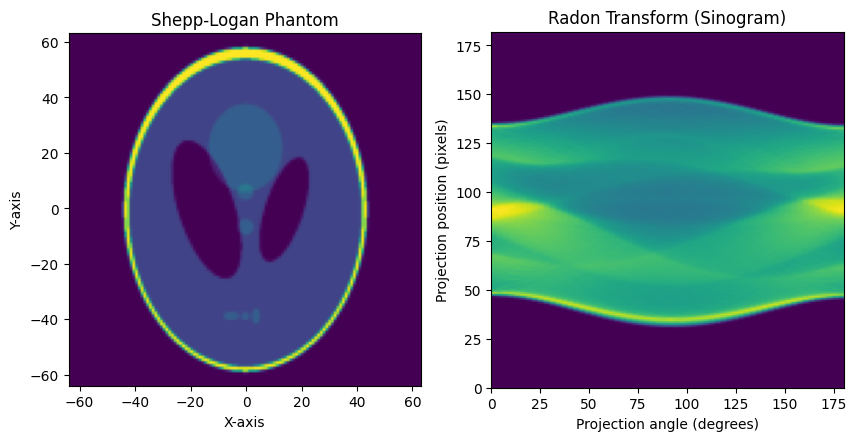

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, resize

phantom = resize(shepp_logan_phantom(), (128, 128))
theta = np.arange(0, 180, 3)
sinogram = radon(phantom, theta=theta, circle=False)

# Display the original image
height, width = phantom.shape
x = np.linspace(-width // 2, width // 2 - 1, width)
y = np.linspace(-height // 2, height // 2 - 1, height)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(phantom, extent=(x.min(), x.max(), y.min(), y.max()))
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Shepp-Logan Phantom')

# Display the Radon transform (sinogram)
plt.subplot(1, 2, 2)
plt.imshow(sinogram, extent=(0, 180, 0, sinogram.shape[0]))
plt.xlabel('Projection angle (degrees)')
plt.ylabel('Projection position (pixels)')
plt.title('Radon Transform (Sinogram)')

plt.show()

## Implementing Filtered Backprojection (FBP)

Here, we are going to implement the **Ram-Lak**, the **Shepp-Logan** and the **Cosine** filter.

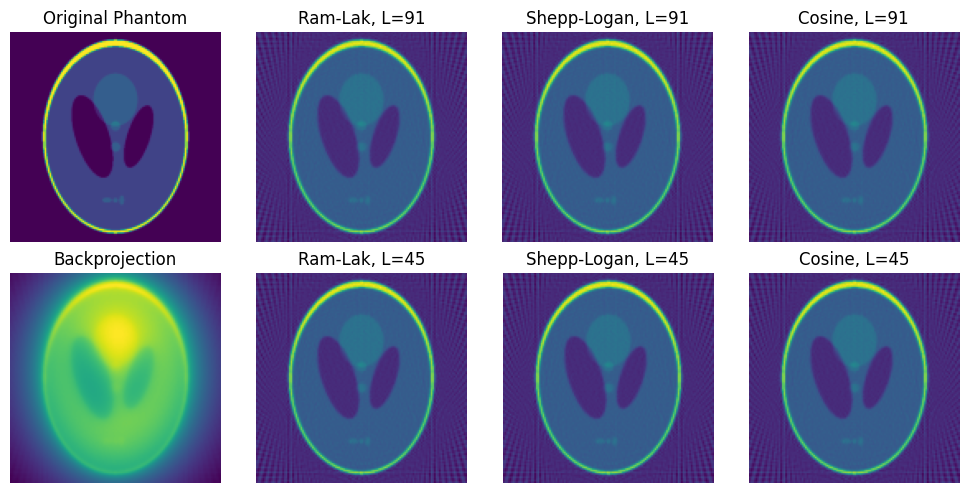

In [2]:
from skimage.transform import iradon


def my_filter(image_sinogram, l, radon_filter: str = 'Ram-Lak'):
    """
    Applies a given filter in the Fourier domain.
    :param image_sinogram: The Radon transform (sinogram) of an image.
    :param l: Cutoff frequency (L = w_max or w_max / 2).
    :param radon_filter: Type of filter ('Ram-Lak', 'Shepp-Logan', 'Cosine').
    :return: Filtered sinogram.
    """
    num_samples, num_projections = image_sinogram.shape  # Corrected axis order
    w_max = num_samples // 2  # Maximum frequency index
    freqs = np.fft.fftfreq(num_samples).reshape(-1, 1)  # Shape (num_samples, 1)

    # Define the Ram-Lak filter
    h = np.abs(freqs)  # Base ramp filter

    # Apply Shepp-Logan or Cosine modifications
    if radon_filter == 'Shepp-Logan':
        h *= np.sinc(freqs / (2 * w_max))
    elif radon_filter == 'Cosine':
        h *= np.cos(np.pi * freqs / (2 * w_max))

    # Apply frequency cutoff
    h[np.abs(freqs) > l / w_max] = 0  # Frequency filtering

    # Reshape H to match sinogram_fft shape
    h = h.flatten()[:, np.newaxis]  # Shape (num_samples, 1)

    # Apply filter in the Fourier domain
    sinogram_fft = np.fft.fft(image_sinogram, axis=0)
    sinogram_filtered = np.real(np.fft.ifft(sinogram_fft * h, axis=0))  # Element-wise multiplication

    return sinogram_filtered


# Define filter parameters
L_max = sinogram.shape[0] // 2
L_half = L_max // 2

filters = ['Ram-Lak', 'Shepp-Logan', 'Cosine']
recon_images = {}

# Apply filtering and reconstruct images
for filter_type in filters:
    for L in [L_max, L_half]:
        filtered_sinogram = my_filter(sinogram, L, filter_type)
        recon_images[(filter_type, L)] = iradon(filtered_sinogram, theta=theta, filter_name=None, circle=False)

# Compute unfiltered backprojection
unfiltered_recon = iradon(sinogram, theta=theta, filter_name=None, circle=False)

# Display results
_, axes_phantom = plt.subplots(2, 4, figsize=(10, 5))
axes_phantom[0, 0].imshow(phantom)
axes_phantom[0, 0].set_title('Original Phantom')
axes_phantom[0, 0].axis('off')
axes_phantom[1, 0].imshow(unfiltered_recon)
axes_phantom[1, 0].set_title('Backprojection')
axes_phantom[1, 0].axis('off')

for (filter_type, L), img in recon_images.items():
    row = 0 if L == L_max else 1
    col = filters.index(filter_type) + 1
    axes_phantom[row, col].imshow(img)
    axes_phantom[row, col].set_title(f'{filter_type}, L={L}')
    axes_phantom[row, col].axis('off')

plt.tight_layout()
plt.show()

Simple **backprojection**, without any filtering gives us a **blurry** image. The **Ram-Lak filter, Shepp-Logan and Cosine filters** give us a **better image**.

## Reconstruction for blurred Images

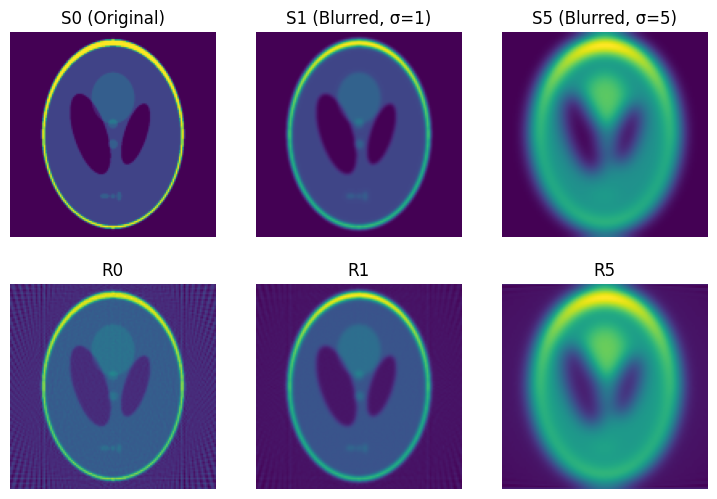

RRMSE(S0, R0): 0.5786125785409824
RRMSE(S1, R1): 0.5657564262382729
RRMSE(S5, R5): 0.5900503898558837


In [3]:
from scipy.ndimage import gaussian_filter

# Create blurred versions of the image
S0 = phantom
S1 = gaussian_filter(phantom, sigma=1)
S5 = gaussian_filter(phantom, sigma=5)

# Compute the Radon transform
sinogram_S0 = radon(S0, theta=theta, circle=False)
sinogram_S1 = radon(S1, theta=theta, circle=False)
sinogram_S5 = radon(S5, theta=theta, circle=False)

# Apply the Ram-Lak filter with L = wmax
wmax = sinogram_S0.shape[0] // 2
filtered_sinogram_S0 = my_filter(sinogram_S0, wmax)
filtered_sinogram_S1 = my_filter(sinogram_S1, wmax)
filtered_sinogram_S5 = my_filter(sinogram_S5, wmax)

# Perform backprojection
R0 = iradon(filtered_sinogram_S0, theta=theta, filter_name=None, circle=False)
R1 = iradon(filtered_sinogram_S1, theta=theta, filter_name=None, circle=False)
R5 = iradon(filtered_sinogram_S5, theta=theta, filter_name=None, circle=False)

# Display the original and blurred images
_, axes_phantom_blur = plt.subplots(2, 3, figsize=(9, 6))
axes_phantom_blur[0, 0].imshow(S0)
axes_phantom_blur[0, 0].set_title('S0 (Original)')
axes_phantom_blur[0, 0].axis('off')
axes_phantom_blur[0, 1].imshow(S1)
axes_phantom_blur[0, 1].set_title('S1 (Blurred, σ=1)')
axes_phantom_blur[0, 1].axis('off')
axes_phantom_blur[0, 2].imshow(S5)
axes_phantom_blur[0, 2].set_title('S5 (Blurred, σ=5)')
axes_phantom_blur[0, 2].axis('off')
# Display the Ram-Lak-filtered back projections
axes_phantom_blur[1, 0].imshow(R0)
axes_phantom_blur[1, 0].set_title('R0')
axes_phantom_blur[1, 0].axis('off')
axes_phantom_blur[1, 1].imshow(R1)
axes_phantom_blur[1, 1].set_title('R1')
axes_phantom_blur[1, 1].axis('off')
axes_phantom_blur[1, 2].imshow(R5)
axes_phantom_blur[1, 2].set_title('R5')
axes_phantom_blur[1, 2].axis('off')
plt.show()


# Compute the RRMSE
def rrmse(a, b):
    return np.sqrt(np.sum((a - b) ** 2)) / np.sqrt(np.sum(a ** 2))


rrmse_S0_R0 = rrmse(S0, R0)
rrmse_S1_R1 = rrmse(S1, R1)
rrmse_S5_R5 = rrmse(S5, R5)

print(f'RRMSE(S0, R0): {rrmse_S0_R0}')
print(f'RRMSE(S1, R1): {rrmse_S1_R1}')
print(f'RRMSE(S5, R5): {rrmse_S5_R5}')

The RRMSE values are **larger** for the **more blurred images**. The **RRMSE(S5, R5)** is the largest, as the image is more blurred.

## RRMSE values for various L values

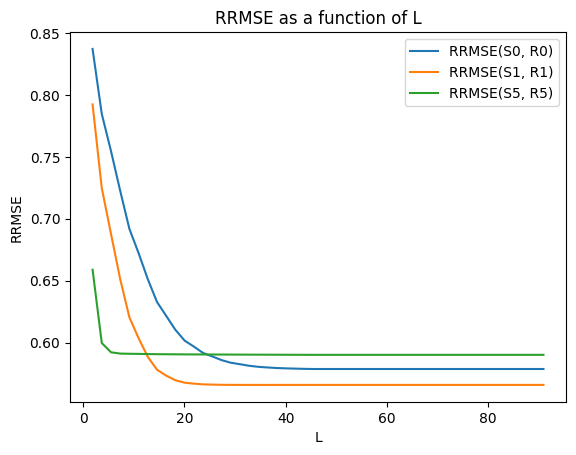

In [4]:
# Plot RRMSE values as a function of L
L_values = np.linspace(wmax / 50, wmax, 50)
rrmse_values_S0 = []
rrmse_values_S1 = []
rrmse_values_S5 = []

for L in L_values:
    filtered_sinogram_S0 = my_filter(sinogram_S0, L)
    filtered_sinogram_S1 = my_filter(sinogram_S1, L)
    filtered_sinogram_S5 = my_filter(sinogram_S5, L)
    R0 = iradon(filtered_sinogram_S0, theta=theta, filter_name=None, circle=False)
    R1 = iradon(filtered_sinogram_S1, theta=theta, filter_name=None, circle=False)
    R5 = iradon(filtered_sinogram_S5, theta=theta, filter_name=None, circle=False)
    rrmse_values_S0.append(rrmse(S0, R0))
    rrmse_values_S1.append(rrmse(S1, R1))
    rrmse_values_S5.append(rrmse(S5, R5))

plt.plot(L_values, rrmse_values_S0, label='RRMSE(S0, R0)')
plt.plot(L_values, rrmse_values_S1, label='RRMSE(S1, R1)')
plt.plot(L_values, rrmse_values_S5, label='RRMSE(S5, R5)')
plt.xlabel('L')
plt.ylabel('RRMSE')
plt.legend()
plt.title('RRMSE as a function of L')
plt.show()

The values converge, **decreasing as L increases** to the RRMSE values obtained in the previous part.